A long, long time ago (to be exact -- in February 2018) I prepared a Shiny app to explore the books of the most popular [Project Gutenberg](https://www.gutenberg.org/catalog/) authors. The original app is still available (and bugged) [via ShinyApps](https://mzgw.shinyapps.io/book-recommendation/), and was inspired by [this article](https://blog.vocapouch.com/do-20-pages-of-a-book-gives-you-90-of-its-words-795a405afe70). I first decided to port the unique words plot from Python to R, then utilised some [readability scripts](https://github.com/mkmozgawa/flescher-readability) I'd written earlier, and all of a sudden it was all nice and Shiny. (ba-dum-tss) Also, it helped that I needed to create some kind of a project for my uni labs.

I recently digged back into the project due to my incessant interest in the concepts of readability tests and other measurable text features. While the more complex work is still underway (I need some data from humans, never easy), I thought the app itself could use some improvements, and at least one of them could potentially be done without touching the existing codebase. Then there's the issue with how to calculate the readability score -- and stay sane.

### Dealing with the books galore

If you consider the "Books on this level" plot, there's way too much data if you go for the B1 level:

![alt text](images/plot_before.png "Books on this level plot -- before removing some items")

This is due to the fact that there are way more books on the A2 - B2 levels than on any else or, putting it in the statistical lingo, the flesch.value vector data is skewed (left-skewed if you look at the flesch.value, and right-skewed if you consider the level). This becomes appearent when you group all the books by the level and count your chickens:

In [101]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [102]:
book_list = pd.read_csv('book_list.csv', sep=',', header=0)

In [103]:
book_list.head()

,gutenberg.id,title,author,gutenberg.author.id,gutenberg.bookshelf,flesch.value,flesch.grade,level,average.goodreads.rating
0,17621,One Day More: A Play In One Act,"Conrad, Joseph",125,One Act Plays,90.418363,5,A1,2.90
1,28554,Beyond Lies the Wub,"Dick, Philip K.",33399,Science Fiction,90.431191,5,A1,3.81
2,28644,Beyond the Door,"Dick, Philip K.",33399,Science Fiction,93.401235,5,A1,3.06
3,32032,Second Variety,"Dick, Philip K.",33399,Science Fiction,91.175281,5,A1,3.96
4,41562,The Hanging Stranger,"Dick, Philip K.",33399,Science Fiction,91.919921,5,A1,3.90


In [104]:
book_list.groupby('level').size()

level
A1     14
A2    155
B1    187
B2     90
C1     22
C2     10
dtype: int64

Another thing becomes apparent when you plot the flesch.value ([https://en.wikipedia.org/wiki/Flesch%E2%80%93Kincaid_readability_tests](click for more info on that)) against the average.goodreads.rating (pulled from the [Goodreads](https://www.goodreads.com/) (API)[https://www.goodreads.com/api]) is that it's also left-skewed (right-skewed on the plot below because of the nature of the Y axis).

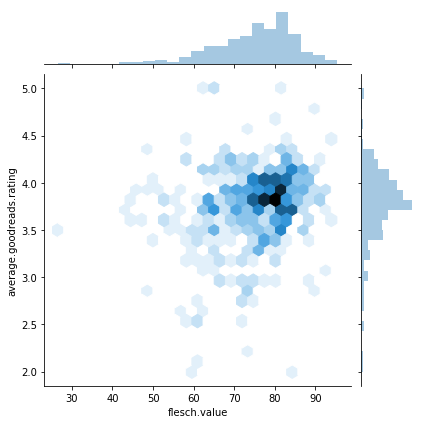

In [105]:
sns.jointplot(x='flesch.value',y='average.goodreads.rating',data=book_list,kind='hex')

What I get from this is that, essentially, the rating may be a useless metric ("every product and business on earth is assigned a numerical rating from 1 to 5 on some site, but everything ends up at 3.7 +/- 0.1, so it means nothing, but we just keep doing it because our first goal is quantification as such, accuracy and precision be damned" to quote [Gary Bernhardt](https://twitter.com/garybernhardt/status/1117664396757520384)). But I promised to myself not to dwell on the past and so I'm not changing the logic of the app, and I shall just pick fewer books for each grade level to make it look nicer on the actual plot. Also, these are the cream of the crop volumes, so maybe they're just really good on average? Or maybe people are afraid to rate them too low?

But how do I pick only some of the books in such a way that I get a sample of each readability level (and Goodreads rating)? Given the plot above, there are some really hot regions (think 3.7 stars, 78 on the Flesch-Kincaid scale) but the rest could potentially stay as it is. As this is more for the demonstration purposes and not some actual sample-sized statistical research, the simplest way would be to first bucket the books in an even more fine manner (90-88 flesch.value, 88-86 flesch.value, and so on) and then from each such bucket, if there is more than one book, choose on the basis of their Goodreads rating (how varied it is).

In [106]:
bins_flesch = np.linspace(0,100,num=101)
cuts_flesch = pd.cut(book_list['flesch.value'], bins_flesch)
bins_rating = np.linspace(0,5,num=11)
cuts_rating = pd.cut(book_list['average.goodreads.rating'], bins_rating)
groups = book_list.groupby(by=[cuts_flesch, cuts_rating])

In [107]:
groups.size().head()

flesch.value  average.goodreads.rating
(26.0, 27.0]  (3.0, 3.5]                  1
(43.0, 44.0]  (3.5, 4.0]                  2
(44.0, 45.0]  (3.5, 4.0]                  1
(46.0, 47.0]  (3.5, 4.0]                  1
(47.0, 48.0]  (2.5, 3.0]                  1
dtype: int64

Let's assume that for each of these buckets, the goal would be to have a single element in it, and this element would be in the middle of that particular bucket. Note that this is going to be a pretty small data frame (I'm starting with <500 records) so performance isn't an issue here. Normally you'd want to pre-allocate indices, and stuff like that.

In [108]:
res_df = pd.DataFrame(columns=list(book_list.columns.values))

In [109]:
# https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

In [110]:
els = []
for key, item in groups:
    g = groups.get_group(key)
    g_mean = g['average.goodreads.rating'].mean()
    g_mean_choice = find_nearest(g['average.goodreads.rating'], g_mean)
    g_choice = g[g['average.goodreads.rating'] == g_mean_choice]
    f = [res_df, g_choice]
    res_df = pd.concat(f)

In [111]:
res_df.head()

,gutenberg.id,title,author,gutenberg.author.id,gutenberg.bookshelf,flesch.value,flesch.grade,level,average.goodreads.rating
469,15,Moby Dick,"Melville, Herman",9,Best Books Ever Listings/Adventure,26.599868,>= 16 (college graduate),C2,3.47
471,16833,Auguste Comte and Positivism,"Mill, John Stuart",1705,Philosophy,43.411004,>= 13 (college),C2,3.65
476,18188,Homer and Classical Philology,"Nietzsche, Friedrich Wilhelm",779,Philosophy,44.382562,>= 13 (college),C2,3.84
468,2009,The Origin of Species by Means of Natural Sele...,"Darwin, Charles",485,Harvard Classics/Biology,46.535282,>= 13 (college),C2,3.97
470,35421,A System of Logic: Ratiocinative and Inductive...,"Mill, John Stuart",1705,Philosophy,47.673194,>= 13 (college),C2,2.82


In [112]:
cuts_flesch_2 = pd.cut(res_df['flesch.value'], bins_flesch)
cuts_rating_2 = pd.cut(res_df['average.goodreads.rating'], bins_rating)
groups = res_df.groupby(by=[cuts_flesch_2, cuts_rating_2])
groups.size().head()

flesch.value  average.goodreads.rating
(26.0, 27.0]  (3.0, 3.5]                  1
(43.0, 44.0]  (3.5, 4.0]                  1
(44.0, 45.0]  (3.5, 4.0]                  1
(46.0, 47.0]  (3.5, 4.0]                  1
(47.0, 48.0]  (2.5, 3.0]                  1
dtype: int64

Now there should be just 1 book per bucket. The final result is 142 books (`res_df.shape[0]`). Plugged this into the existing app gives us the following result:

![alt text](images/plot_after.png "Books on this level plot -- after removing some items")

### Calculating readability

Another thing I wanted to touch upon is the readability score calculation -- which is pretty hard. To calculate the Flesch-Kincaid readability score you need to correctly parse the text into sentences, words and syllables. The raw implementation of the formula would be as follows:

In [3]:
def calculate_flesch_score(no_of_sentences, no_of_words, no_of_syllables):
    return 206.835 - 1.015 * (no_of_words / no_of_sentences) - 84.6 * (no_of_syllables / no_of_words)

Even leaving aside the issue of what is a word vs what is a sentence (take [Inuit languages with their extreme agglutination](https://en.wikipedia.org/wiki/Inuit_languages#Morphology_and_syntax)), determining the syllable count of a text is not that easy. You can use [CMUDict](http://www.speech.cs.cmu.edu/cgi-bin/cmudict), which is conveniently available via the nltk package, but there are a lot of words missing from there. Then there's [Pyphen](https://pyphen.org/) but it's pretty error-prone. I also came across the [Readability package](https://pypi.org/project/readability/).

Let's see how all these perform on the benchmark of "Heart of Darkness", one of the rare cases of the books I hate so much, any time I see a copy somewhere I want to throw it out of the closest window:

In [75]:
import nltk
from nltk import word_tokenize, sent_tokenize
from nltk.corpus import cmudict
import readability
import pyphen
import re

In [179]:
f = open('heart_of_darkness.txt')
raw = f.read()

In [180]:
raw.find('The Nellie')

646

In [181]:
raw.find('End of the Project Gutenberg EBook of Heart of Darkness, by Joseph Conrad')

211098

In [182]:
raw = raw[646:211098]

In [183]:
lower_parsed = re.sub('[^0-9a-zA-Z]+', ' ', raw).lower()

In [184]:
words = word_tokenize(lower_parsed)

In [71]:
len(words)

39064

In [89]:
unique_words = set(words)

In [85]:
len(unique_words)

5727

In [64]:
sentences = sent_tokenize(raw)

In [67]:
len(sentences)

2417

This gives me 39064 words (5727 of them unique) and 2417 sentences. Let's see how many of these words can be found in the CMUdict:

In [76]:
cmudict = cmudict.dict()

In [90]:
no_dict = []
for word in unique_words:
    if word not in cmudict.keys():
        no_dict.append(word)

In [91]:
len(no_dict)

359

This means that 359 unique words are not accounted for in the CMUdict. Let's see how often they appear in the whole book:

In [96]:
c = 0
for unique_word in no_dict:
    for word in words:
        if unique_word == word:
            c += 1
print(c)

507


That's a total of 507 words out of 39064, or ~1.3% of all the words in the book. Since this is a quick and dirty solution let's say I can live with this fact, and move on. The plan is as follows:
1. create a lookup dictionary based off the stress patterns in the CMUdict,
2. calculate the number of syllables in the whole book based off the lookup dictionary.

The join-fu and error handling is due to the CMUdict sometimes having two different pronunciation of the same word (obviously, but not useful to me at that moment).

In [202]:
lookup_dict = {}
reg = re.compile(r'[^\d]+')

for word in unique_words:
    if word not in cmudict.keys():
        lookup_dict[word] = 1
    else:
        try:
            lookup_dict[word] = len(reg.sub('', ''.join(cmudict[word][0])))
        except TypeError:
            lookup_dict[word] = len(reg.sub('', ''.join(cmudict[word][0][0])))

In [203]:
n_syl = 0
for word in words:
    n_syl += lookup_dict[word]
print(n_syl)

52487


52487 sounds a bit low, but let's see how this translates into the score:

In [204]:
print(calculate_flesch_score(len(sentences), len(words), n_syl))

76.76050250923326


Another implementation, now fetching the syllable count with Pyphen:

In [170]:
import pyphen
dic = pyphen.Pyphen(lang='en_UK') # In reality, Conrad was a Pole.

Pyphen returns a hyphenated string; I'm going to count these hyphens and add 1 to get the predicted number of syllables.

In [174]:
lookup_dict = {}
reg = re.compile(r'[^-]+')

for word in unique_words:
    lookup_dict[word] = len(reg.sub('', word))+1

In [176]:
n_syl = 0
for word in words:
    n_syl += lookup_dict[word]
print(n_syl)

39064


This gives me 39064 syllables, which is even more dubious.

In [177]:
print(calculate_flesch_score(len(sentences), len(words), n_syl))

105.8303827058337


This makes no sense whatsover. A score of 105 would be for sentences of the style "I see you." (essentially, a lot of single-syllable words in really short sentences), and this book is far from that. Let's see the final implementation via the Readability package:

In [196]:
import readability

In [194]:
sentences = [s.replace('\n', ' ') for s in sentences]
text = '\n'.join(sentences)

In [197]:
results = readability.getmeasures(text, lang='en')

In [198]:
print(results['readability grades']['FleschReadingEase'])

82.8232249133162


A score of almost 83 again seems a bit too high but it's at least close to the one calculated with the CMU dictionary. Finally, let's see how the treetagger-based implementation performed last year:

In [201]:
book_list[book_list['title']=='Heart of Darkness']

,gutenberg.id,title,author,gutenberg.author.id,gutenberg.bookshelf,flesch.value,flesch.grade,level,average.goodreads.rating
219,219,Heart of Darkness,"Conrad, Joseph",125,Best Books Ever Listings/Movie Books,77.935178,7,B1,3.42


The treetagger version has a similar score of ~78. Maybe I just really hate this book...